03 - Accessing and Querying the Detect Database
=======

This notebook demonstrates how to open the HDF5 containter for the HETDEX line detections database. This database is a source list of line emission detections. There are three tables contained within this HDF5 file: 

1. Detections - this is the main database of line detection sources. It provides the position and central wavelength of each detection and corresponding lines fluxes. A source detection corresponds to an emission line so it is possible to have multiple line detections at different wavelengths for a single source. The table also lists a measurement in a single dithered observation only.


2. Fibers - for each source dectection, this table lists information about each fiber used to extract the flux measurment and weighted spectrum


3. Spectra - for each source, this table contains arrays of wavelength and 1D flux-weighted aperture summed data and corresponding errors. Non-calibrated spectra is also provided in counts


In [ ]:
import sys
import os
import os.path
import subprocess
import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table, Column

In [4]:
## open the detect file using pytables 
detect_file = '/users/erin/Desktop/detect_test2.h5'
fileh = tb.open_file(detect_file)

In [5]:
# to access the main detetion table:
detects = fileh.root.Detections 

# to see a list of columns in the main detection table
detects.cols

/Detections.cols (Cols), 29 columns
  detectid (Column(94636,), int64)
  detectname (Column(94636,), |S20)
  shotid (Column(94636,), int64)
  date (Column(94636,), int32)
  obsid (Column(94636,), int32)
  ra (Column(94636,), float32)
  dec (Column(94636,), float32)
  wave (Column(94636,), float32)
  wave_err (Column(94636,), float32)
  flux (Column(94636,), float32)
  flux_err (Column(94636,), float32)
  linewidth (Column(94636,), float32)
  linewidth_err (Column(94636,), float32)
  continuum (Column(94636,), float32)
  continuum_err (Column(94636,), float32)
  sn (Column(94636,), float32)
  sn_err (Column(94636,), float32)
  chi2 (Column(94636,), float32)
  chi2_err (Column(94636,), float32)
  multiframe (Column(94636,), |S20)
  fiber_num (Column(94636,), int32)
  x_raw (Column(94636,), int32)
  y_raw (Column(94636,), int32)
  amp (Column(94636,), |S2)
  datevobs (Column(94636,), |S12)
  ifuid (Column(94636,), int32)
  ifuslot (Column(94636,), int32)
  inputid (Column(94636,), |S32)
 

The entire table or an entire column can be pulled into local memory into an array using [:] or you can slice as you wish, but likely you want to query to figure out which data you are interested in.


In [ ]:
ra = detects.cols.ra[:]

If you don't need the entire table its better to subselect a part of the table. For example, read only the table where all detections between 4200AA and 4250AA


In [ ]:
detect_table = detects.read_where("(wave > 4200) & (wave < 4250)"))

This reads the database into a numpy table which you can then directly work with as usual. For example, read in the detectid, or the input detect name:

In [9]:
detect_table['detectid']

array([1000000060, 1000000106, 1000000139, ..., 1000094474, 1000094563,
       1000094602])

In [10]:
detect_table['inputid']

array(['20180317v010_268', '20180317v011_198', '20180317v011_603', ...,
       '20180316v016_896', '20180317v008_104', '20180317v008_34'],
      dtype='|S32')

Let's work through a quick example. Say I want to find, save and plot the 1D spectra for all objects with SN>30 and a central wavelength within 4000-4200 AA in COSMOS (at RA=150deg, DEC=2.2deg) I could do the following query:

In [35]:
detect_table = detects.read_where("(sqrt((ra-150)**2 + (dec-2.2)**2) < 1) & (sn>30) & (wave > 4000) & (wave < 4200)")

To find out how many objects are in the table just use np.size:

In [36]:
np.size(detect_table)

8

To store this subset into an output table, figure out columns you want to export and store into another table then write to a file.

In [37]:
outputtable = detect_table[['detectid','inputid','flux','flux_err','sn','sn_err','wave','wave_err']]
ascii.write(outputtable,'output.dat', overwrite=True)

The 1D flux-weighted spectra are stored in the Spectra table:

In [57]:
spectra = fileh.root.Spectra
spectra.cols

/Spectra.cols (Cols), 8 columns
  detectid (Column(94635,), int64)
  wave1d (Column(94635, 1036), ('<f4', (1036,)))
  spec1d (Column(94635, 1036), ('<f4', (1036,)))
  spec1d_err (Column(94635, 1036), ('<f4', (1036,)))
  counts1d (Column(94635, 1036), ('<f4', (1036,)))
  counts1d_err (Column(94635, 1036), ('<f4', (1036,)))
  apsum_counts (Column(94635, 1036), ('<f4', (1036,)))
  apsum_counts_err (Column(94635, 1036), ('<f4', (1036,)))

If you want to store each spectra to a file:

In [58]:
for i in np.arange(np.size(detect_table)):
    source = detect_table['detectid'][i]
    spectra_table = spectra.read_where("detectid == source")
    data = Table()
    data['wave1d'] = Column( spectra_table['wave1d'][0], unit='AA')
    data['spec1d'] = Column( spectra_table['spec1d'][0], unit='1e-17 erg/s/cm^2')
    data['spec1d_err'] = Column( spectra_table['spec1d_err'][0], unit='1e-17 erg/s/cm^2') 
    ascii.write(data, 'spec_'+str(source)+'.dat', overwrite=True)

Using the function plot_spectrum, plot the 1D spectrum of the first object in the list.

In [43]:
def plot_spectrum(self, xlim=None, ylim=None):
    plt.figure(figsize=(8, 6))
    plt.errorbar(self['wave1d'], self['spec1d'], yerr=self['spec1d_err'])
    plt.title("DetectID "+str(self['detectid']))
    plt.xlabel('wave (AA)')
    plt.ylabel('flux (erg/s/cm^2/AA)')
    if xlim is not None:
        plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
    plt.show()

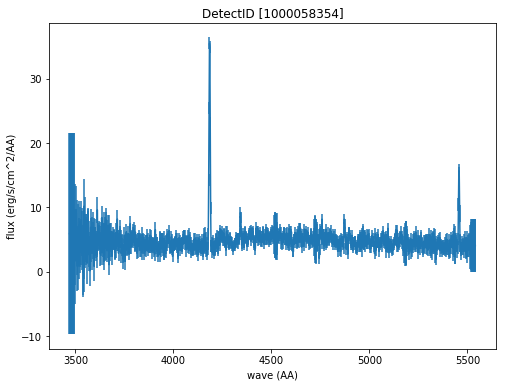

In [53]:
source = detect_table['detectid'][0]
spectra_table = spectra.read_where("detectid == source")
plot_spectrum(spectra_table)

To constrain x-axis of the plot to the line emission:

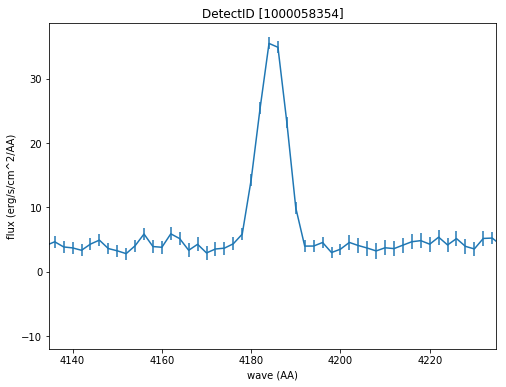

In [55]:
cw = detect_table['wave'][0]
plot_spectrum(spectra_table, xlim=[cw-50,cw+50])

You can find a list of all fibers used in the measurement in the Fibers table. The Fibers table and its associated columns can be accessed similar to the Spectra table by searching for a match in the the detectid column. 

In [56]:
fibers = fileh.root.Fibers
fibers.cols

/Fibers.cols (Cols), 20 columns
  detectid (Column(283905,), int64)
  ra (Column(283905,), float32)
  dec (Column(283905,), float32)
  multiframe (Column(283905,), |S20)
  fiber_num (Column(283905,), int32)
  x_ifu (Column(283905,), float32)
  y_ifu (Column(283905,), float32)
  date (Column(283905,), int32)
  obsid (Column(283905,), int32)
  expn (Column(283905,), |S5)
  distance (Column(283905,), float32)
  timestamp (Column(283905,), |S17)
  wavein (Column(283905,), float32)
  flag (Column(283905,), int32)
  weight (Column(283905,), float32)
  ADC (Column(283905, 5), ('<f4', (5,)))
  amp (Column(283905,), |S3)
  ifuid (Column(283905,), int32)
  ifuslot (Column(283905,), int32)
  specid (Column(283905,), int32)

Access the fiber table for the above source:

In [60]:
fiber_table = fibers.read_where("detectid == source") 

In [66]:
fiber_table

array([(1000075967, 150.31746, 2.2877576, 'multi_316_022_052_LL', 1, 24.15, -13.22, 20181215, 31, 'exp01', 1.10141, '20181215T093747.0', 4181.12, 0, 127.2 , [0.623, 0.831, 1.   , 1.01 , 1.051], 'L', 52, 22, 16),
       (1000075967, 150.3178 , 2.2883806, 'multi_316_022_052_LU', 0, 22.88, -15.42, 20181215, 31, 'exp01', 2.33328, '20181215T093747.0', 4181.12, 0,   9.32, [0.513, 0.737, 1.   , 1.006, 1.051], 'U', 52, 22, 16),
       (1000075967, 150.31711, 2.2875412, 'multi_316_022_052_LL', 0, 22.88, -11.02, 20181215, 31, 'exp02', 2.44393, '20181215T094443.8', 4181.12, 0,   7.06, [0.681, 0.845, 1.   , 1.006, 1.028], 'L', 52, 22, 16)],
      dtype=[('detectid', '<i8'), ('ra', '<f4'), ('dec', '<f4'), ('multiframe', 'S20'), ('fiber_num', '<i4'), ('x_ifu', '<f4'), ('y_ifu', '<f4'), ('date', '<i4'), ('obsid', '<i4'), ('expn', 'S5'), ('distance', '<f4'), ('timestamp', 'S17'), ('wavein', '<f4'), ('flag', '<i4'), ('weight', '<f4'), ('ADC', '<f4', (5,)), ('amp', 'S3'), ('ifuid', '<i4'), ('ifuslot', '